### Natural Language Processing - Assignment 1

__Group Members:__
1) Aanal Patel - C0910376
2) Bimal Shresta - C0919385
3) Danilo Diaz - C0889539
4) Ernie Sumoso - C0881591
5) Jayachandhran Saravanan - C0910392

### Index
- __0. Data Source Explanation__
- __1. Dataset Collection__
- __2. Exploratory Data Analysis__
- __3. Data Cleaning & Text Processing__
- __4. Word Vectorization methods__
- __5. Word Clouds__
- __6. Model Building__
- __7. Evaluating Model Results__

### 0. Data Source explanation

We are providing a file __VideoCommentsThreatCorpus.txt__, from which we will extract our data.

The origin of these texts are from 

The data is consolidated into a __plain text file__ and hosted within a __Google Drive repository__.

### 1. Dataset Collection
Let's start by acquiring our dataset from an external source.

The columns of our dataset are as follows:
- __text__: raw textual data
- __label__: 0 --> the text does not contain a threat, 1 --> the text contains a threat

First, to gather our data, let's import some required libraries.

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import os # used for file manipulation
import sys # used for file manipulation
import re # used for regular expression
from urllib import request

Let's create a __Helper class__ that will allow us to __extract (download) the data__ from its original source (Google Drive).

This class will also allow us to __read the file and return a DataFrame__ from Pandas library.

In [3]:
# Helper class to download and read the dataset
class Helper:
    def __init__(self, path, id_path):
        self.path = path
        self.id_path = id_path

    def download_dataset(self):
        # Download the dataset from the original source Google Drive
        url = f"https://drive.google.com/uc?export=download&id={self.id_path}"
        request.urlretrieve(url, self.path)

    def read_dataset(self, path):
        # Read the dataset, and return the DataFrame from Pandas
        def read_lines(lines):
            is_header = True
            for line in lines:
                if is_header:
                    is_header = False
                    continue

                if not line or line.isspace():
                    is_header = True
                    continue
                # let's create a generator so we don't store the whole content in memory
                label, comment = line.split(maxsplit=1)
                yield comment, int(label)

        with open(path, encoding="utf-8") as file:
            data = read_lines(file)
            df = pd.DataFrame.from_records(data, columns=["text", "label"])

        return df

Let's __instantiate our Helper class__ and __donwload the data from its original source__ and obtain the data from the file as a __DataFrame__.

In [43]:
# instantiate our custom Helper class
helper = Helper(
    path='dataset',
    id_path='13XlJ4uhxxGprn6mnXwXNvV9PxSNyZCsY'
)
# download our dataset from its original source
helper.download_dataset()
# read the dataset as a DataFrame from Pandas
df = helper.read_dataset('dataset')
df.head()

,text,label
0,It's because Europeans do not want to change t...,0
1,The Muslims there do not want to assimilate pr...,0
2,But it's ok....because Europe will soon rebel ...,1
3,I forsee a big civil war in Europe in the futu...,0
4,"ISLAM – A Simple, Humanitarian and Attractive ...",0


Now we have the dataset ready for an exploratory data analysis (EDA) inside the __df__ variable.

### 2. Exploratory Data Analysis

Let's start our EDA. For this task we have implemented a class called __ExploratoryDataAnalysis__ that takes the following __parameters for initialization__:
- DataFrame from Pandas library
- String defining target column name

... and calculates some basic analysis over the data.

Some of the implemented methods are capable of:

- Displaying and plotting the __Value counts of our target column__
- Displaying and plotting the number of rows with __missing values__ within our dataframe
- Displaying and plotting the number of __duplicated rows__ within our dataframe

The purpose behind creating a class and methods was to avoid repetitive code and to enable ourselves to re-use the code with different datasets.

In [5]:
import matplotlib.pyplot as plt

In [9]:
class ExploratoryDataAnalysis:
    
    def __init__(self, df, target_column_name, lines=30):
        self.df = df
        self.target_column_name = target_column_name
        self.lines = lines
    
    def print_line(self):
        print("-" * self.lines)
    
    def display_shape(self):
        # check for the shape (number of rows and columns) of the dataset
        print("SHAPE")
        print("# Rows:\t", df.shape[0])
        print("# Columns:", df.shape[1])
    
    def display_target_value_counts(self, percentage=False):
        # check for the distribution of target values, take percentage flag into account
        print("TARGET VALUE COUNTS", percentage * "PERCENTAGE (%)")
        print(df[self.target_column_name].value_counts(normalize = percentage) * (100 if percentage else 1))
        print("Total:", "100.00 %" if percentage else df[self.target_column_name].count())
        
    def display_missing_values(self, percentage=False):
        # check for missing values, take percentage flag into account
        print("MISSING VALUES", percentage * "PERCENTAGE (%)")
        print(df.isnull().mean() * 100 if percentage else df.isnull().sum())
        print("Total:", "100.00 %" if percentage else df.isnull().sum().sum())
        
    def display_duplicates(self, percentage=False):
        # check for duplicate values, take percentage flag into account
        print("DUPLICATED ROWS", percentage * "PERCENTAGE (%)")
        print("Total:", "{:.2f} %".format(df.duplicated().mean() * 100) if percentage else df.duplicated().sum())
        
    def display_basic_analysis(self):
        # make use of the previous defined methods to display a basic EDA
        self.print_line()
        self.display_shape()
        self.print_line()
        self.display_target_value_counts()
        self.print_line()
        self.display_target_value_counts(percentage=True)
        self.print_line()
        self.display_missing_values()
        self.print_line()
        self.display_missing_values(percentage=True)
        self.print_line()
        self.display_duplicates()
        self.print_line()
        self.display_duplicates(percentage=True)
        self.print_line()
    
    def plot_target_value_counts(self, ax):
        # to plot we need to set our x and y values first
        x = df[self.target_column_name].unique()
        y = df[self.target_column_name].value_counts()
        # plot the bar in the subplot canvas, using a random generated color
        ax.bar(x, y, color=np.random.rand(3,))
        
        # let's add annotation to our bar graph
        for x_, y_ in zip(x, y): # zip creates the following tuples: (1st x value, 1st y value), (2nd, 2nd) ...
            label = "{:,} ({:.2f} %)".format(y_, y_ * 100/y.sum()).replace(',', "'")
            # annotate at the x and y position, add some offset to center the annotations
            ax.annotate(label, (x_ - 0.2, y_ + 150))
            
        # let's add some titles to the subplot and axis
        ax.title.set_text("Target Value Counts")
        ax.set_xlabel("Unique Values")
        ax.set_ylabel("Value Counts")
        
    def plot_missing_values(self, ax):
        # to plot we need to set our x and y values first
        x = df.columns.to_list()
        y = df.isnull().sum()
        ax.bar(x, y, color=np.random.rand(3,), width = 0.4)
        
        # if there's no missing values we can write it down explicitely using text method
        if y.sum().sum() == 0:
            ax.text(0.5, 0.5, 'No Missing Values', transform=ax.transAxes,
                    fontsize=40, color='gray', alpha=0.5, ha='center', va='center', rotation=25)
        
        # let's add some titles to the subplot and axis
        ax.title.set_text("Missing Values")
        ax.set_xlabel("Column Name")
        ax.set_ylabel("# Rows with Missing Values")
        
    def plot_duplicates(self, ax):
        # to plot we need to set our x and y values first
        x = ['# Non-duplicated Rows', '# Duplicated Rows']
        y = [df.shape[0] - df.duplicated().sum(), df.duplicated().sum()]
        ax.bar(x, y, color=np.random.rand(3,), width = 0.4)
        
        # let's add annotation to our bar graph
        for x_, y_ in enumerate(y): # zip creates the following tuples: (1st x value, 1st y value), (2nd, 2nd) ...
            label = "{:,} ({:.2f} %)".format(y_, y_ * 100/sum(y)).replace(',', "'")
            # annotate at the x and y position, add some offset to center the annotations
            ax.annotate(label, (x_ - 0.2, y_ + 150))
            
        # let's add some titles to the subplot and axis
        ax.title.set_text("Duplicated Rows")
        ax.set_ylabel("# Rows")
        
    def plot_pie_target_value_counts(self, ax):
        # let's set the unique values of our target column, and their value counts
        labels = df[self.target_column_name].unique()
        value_counts = df[self.target_column_name].value_counts()
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/value_counts.sum() for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = [np.random.rand(3,) for i in range(len(x))] # set random colors
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_pie_missing_values(self, ax):
        # let's set the unique values of our target column, and their value counts
        labels = ['Non-missing', 'Missing']
        value_counts = [df[df.notnull().any(axis=1)].shape[0], # number of rows with non-missing values
                        df[df.isnull().any(axis=1)].shape[0]]  # number of rows with any missing value
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/df.shape[0] for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = [np.random.rand(3,) for i in range(len(x))] # set random colors
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_pie_duplicates(self, ax):
        # let's set the unique values of our target column, and its value counts per unique value
        labels = ['Non-duplicated', 'Duplicated']
        value_counts = [df.shape[0] - df.duplicated().sum(), df.duplicated().sum()]
        
        # let's set the percentage of each value count, explode and color values
        x = [val * 100/df.shape[0] for val in value_counts]
        explode = [0.1 for i in range(len(x))]
        colors = [np.random.rand(3,) for i in range(len(x))] # set random colors
        
        # finally, let's plot the pie
        ax.pie(x, explode, autopct="%.2f", labels=labels, colors=colors)
        
    def plot_basic_analysis(self):
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (20,10)) # rows, columns
        self.plot_target_value_counts(ax1)
        self.plot_missing_values(ax2)
        self.plot_duplicates(ax3)
        self.plot_pie_target_value_counts(ax4)
        self.plot_pie_missing_values(ax5)
        self.plot_pie_duplicates(ax6)

In [10]:
eda = ExploratoryDataAnalysis(df, "label")
eda.display_basic_analysis()

------------------------------
SHAPE
# Rows:	 28643
# Columns: 2
------------------------------
TARGET VALUE COUNTS 
label
0    27256
1     1387
Name: count, dtype: int64
Total: 28643
------------------------------
TARGET VALUE COUNTS PERCENTAGE (%)
label
0    95.15763
1     4.84237
Name: proportion, dtype: float64
Total: 100.00 %
------------------------------
MISSING VALUES 
text     0
label    0
dtype: int64
Total: 0
------------------------------
MISSING VALUES PERCENTAGE (%)
text     0.0
label    0.0
dtype: float64
Total: 100.00 %
------------------------------
DUPLICATED ROWS 
Total: 352
------------------------------
DUPLICATED ROWS PERCENTAGE (%)
Total: 1.23 %
------------------------------


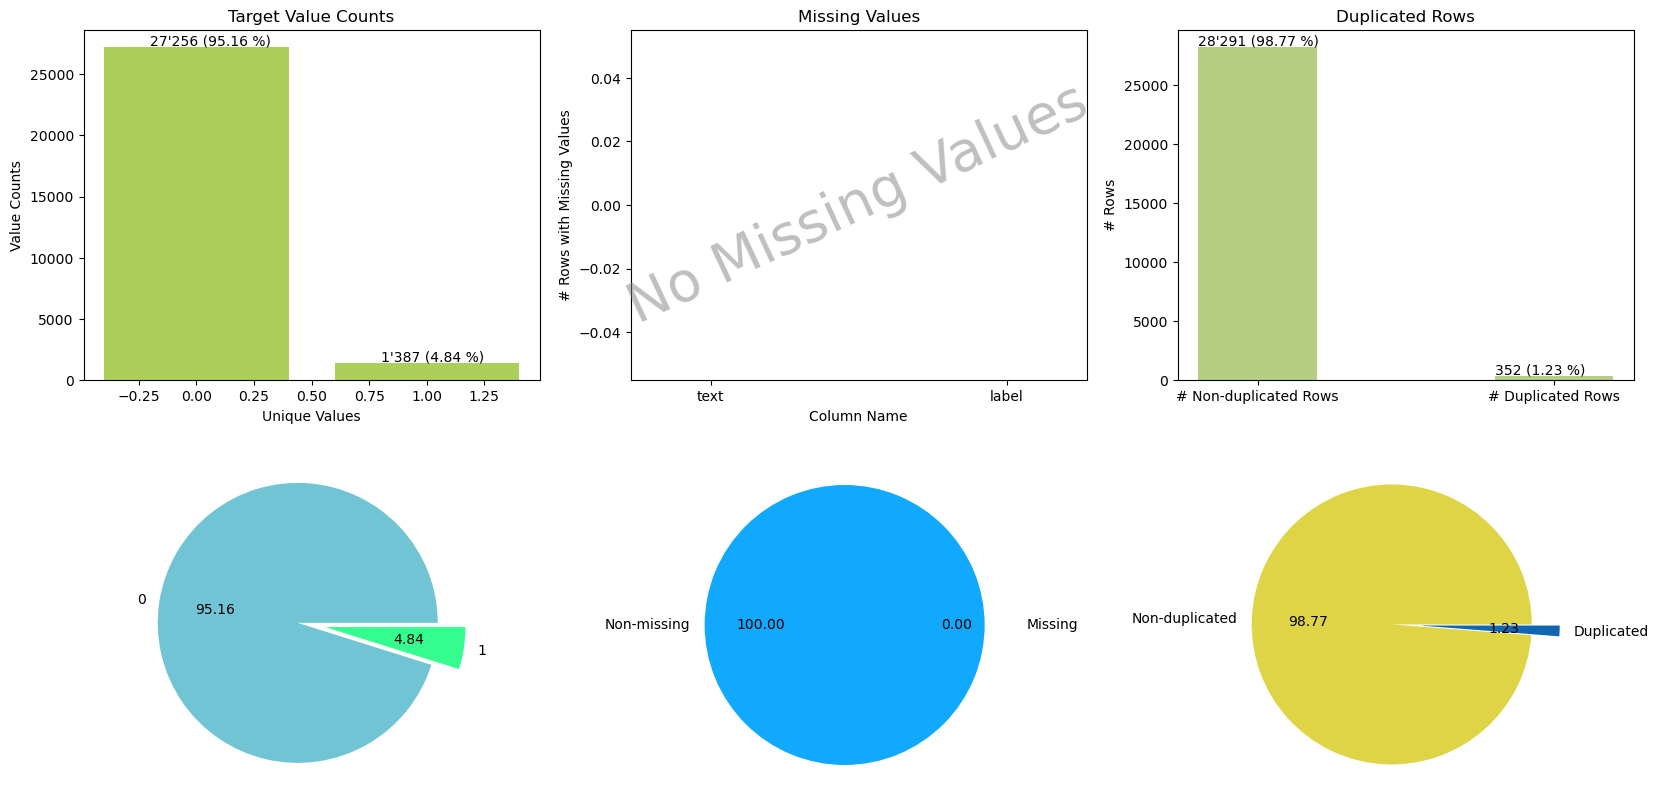

In [98]:
eda.plot_basic_analysis()

In [77]:
# counting the number of unique char occurrences within all of the texts
char_counts = {}
for _, row in df.iterrows():
    for ch in row[['text']][0]:
        char_counts[ch] = char_counts.get(ch, 0) + 1
print(char_counts)

{'I': 15359, 't': 143857, "'": 7006, 's': 109130, ' ': 374190, 'b': 24749, 'e': 192112, 'c': 40189, 'a': 134122, 'u': 60293, 'E': 11970, 'r': 96203, 'o': 129367, 'p': 29351, 'n': 110246, 'd': 58196, 'w': 34106, 'h': 83638, 'g': 30934, 'i': 123433, 'y': 38119, 'f': 28939, 'l': 79710, 'm': 46427, 'k': 16958, '.': 27248, '\n': 28643, 'T': 11064, 'M': 6293, 'v': 16596, 'S': 9165, 'B': 3240, ',': 16314, 'j': 3364, 'q': 1198, 'L': 6537, 'A': 12369, '–': 35, 'H': 6373, 'R': 6411, 'W': 4626, 'C': 4799, 'O': 7875, 'N': 6919, 'D': 4092, 'P': 2959, 'Q': 601, 'U': 4643, '“': 74, '”': 75, '(': 1384, 'J': 2000, '’': 117, 'x': 2205, '3': 689, '5': 872, ')': 1710, '-': 2860, '2': 1191, '0': 2284, '8': 424, 'V': 1109, '1': 1793, '9': 822, '7': 433, '4': 604, '%': 265, 'F': 2784, ':': 1277, '"': 3404, 'z': 1870, '?': 3846, 'K': 2166, 'Y': 3729, '!': 6092, 'G': 3230, '/': 619, '—': 16, '=': 235, 'X': 167, '_': 59, '\xad': 69, 'Z': 258, '\ufeff': 525, '@': 232, '6': 451, '&': 622, ';': 319, '#': 211, 'ق':

In [109]:
# let's calculate the number of alphabetic, alphanumeric and non-alphanumeric characters
english_chars = [ch for ch in char_counts.keys() if ch.isascii() and ch.isalpha()]
alpha_chars = [ch for ch in char_counts.keys() if ch.isalpha()]
numeric_chars = [ch for ch in char_counts.keys() if ch.isnumeric()]
alphanumeric_chars = [ch for ch in char_counts.keys() if ch.isalnum()]
non_alphanumeric_chars = [ch for ch in char_counts.keys() if not ch.isalnum()]

english_dict = {}
for k, v in char_counts.items():
    if k.isalpha() and k.isascii():
        english_dict[k] = v
sum(english_dict.values())

1776050

In [111]:
'ظ'.isalpha()

True

In [112]:
!python --version

Python 3.11.5


### 3. Data Cleaning and Processing

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of words in each comment
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Count the number of characters in each comment
df['char_count'] = df['text'].apply(lambda x: len(x))

# Count the number of special characters in each comment
df['special_char_count'] = df['text'].apply(lambda x: len([c for c in x if c in ('!','@','#','$','%','^','&','*','(',')','_','+','{','}','|',':','"','<','>','?','`','~',';',',','.','/','\\','[',']')]))

# Count the number of numerics in each comment
df['numerics_count'] = df['text'].apply(lambda x: len([c for c in x if c.isdigit()]))

# Count the number of uppercase words in each comment
df['upper_count'] = df['text'].apply(lambda x: len([c for c in x if c.isupper()]))

# Count the number of lowercase words in each comment
df['lower_count'] = df['text'].apply(lambda x: len([c for c in x if c.islower()]))

# Count the number of words in each comment
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Count the number of stopwords in each comment
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['stopwords_count'] = df['text'].apply(lambda x: len([c for c in x.split() if c in stop]))

# Count the number of unique words in each comment
df['unique_words_count'] = df['text'].apply(lambda x: len(set(x.split())))
df.head()



,text,label,word_count,char_count,special_char_count,numerics_count,upper_count,lower_count,stopwords_count,unique_words_count
0,It's because Europeans do not want to change t...,0,20,111,1,0,3,86,11,18
1,The Muslims there do not want to assimilate pr...,0,18,107,1,0,4,84,7,18
2,But it's ok....because Europe will soon rebel ...,1,24,132,6,0,3,98,14,21
3,I forsee a big civil war in Europe in the futu...,0,18,94,2,0,3,71,8,16
4,"ISLAM – A Simple, Humanitarian and Attractive ...",0,8,55,1,0,10,35,1,8


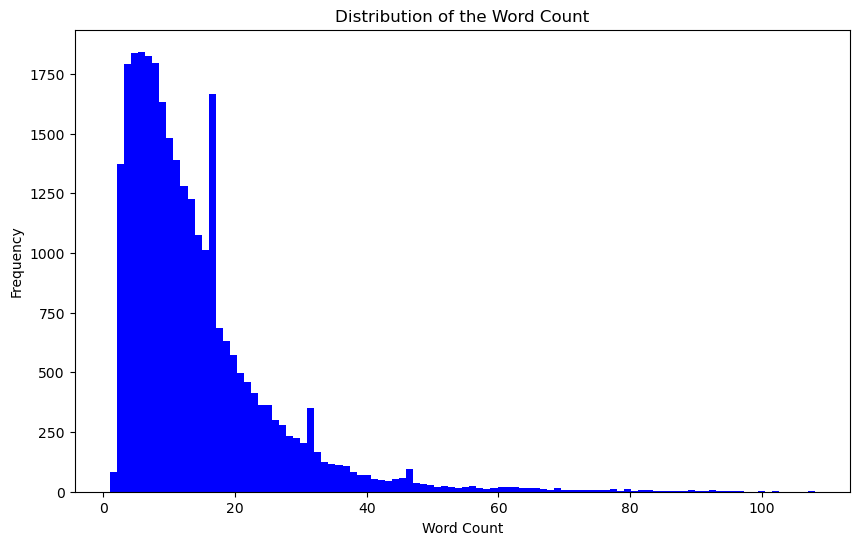

In [14]:
# Plot the distribution of the word count

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=100, color='blue')
plt.title('Distribution of the Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [31]:
# Plot the distribution of the stopword count

In [32]:
# Apply bag of words to the dataset

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df['text']).toarray()


In [33]:
cv.get_feature_names_out()

array(['00', '000', '004', ..., 'ٱلز', 'ٱلس', 'ٱلل'], dtype=object)

In [34]:
feature_names = cv.get_feature_names_out()
pd.DataFrame(bag_of_words, columns = feature_names)

,00,000,004,005,008,009,01,0131,02,03,...,يمكن,ين,يه,يهودية,يوميا,ٱل,ٱلذ,ٱلز,ٱلس,ٱلل
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28639,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28641,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Perform Clean up and data analysis

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
import string
from nltk.corpus import stopwords
from nltk import word_tokenize

In [ ]:
#sentence tokinization

df['sent_token']=df.text.apply(sent_tokenize)

In [ ]:
df[df.sent_token.str.len()>4]

In [ ]:
#removing other non alphabetic words 

df['word_english_aplha']=df['text'].replace('[^\w\s]','')

In [ ]:
df[df['word_english_aplha'].str.contains('ٱلس')]

In [ ]:
def clean_column(dataframe):

    """
    arg: passing the text column
    
    function: check for non-alpha values using ascii method, remove digits, remove punctuation, special characters,
    word tokenization,stopword removal and unwanted white space
    
    return: new column named cleaned_v_1
    """
    #making sure we are just passing the right column onlu
    comment= dataframe.text
    # removing no alpha values
    comment = re.sub(r'[^\w\s,]', '', comment)
    #removing new line character 
    comment = re.sub(r'\n','',comment)
        #removing unwanted characters.
    # not using ,. because it might lead to joining to words if there is no space
    comment=''.join([y.lower() for y in comment if y.isalpha() or y in " ,.'"])
    #removing . , / and other special character
    comment= re.sub(r'[\,\.\']',' ',comment)
    # digits and non- ascii value removal --> as our text contains non-english words
    comment = re.sub(r'\d+', '', comment)
    comment = ''.join(letter for letter in comment if ord(letter) < 128)
    # punctuation
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    #extra white spaces are found, revoming that
    comment = re.sub(r'\s{2,}', '', comment)
    #initializing the stop words present in NLTK lib
    stop_words=stopwords.words('english')
    #adding few stopwords using extend method
    addd=[ 'd','ll', 'm', 'o', 're', 've', 'y', 'ma','even','ur','u']
   
    #set is used to remove the stopwords easily
    stop_words=set(stop_words)
    # after doing research on the stopwords, we are  modifying the stopwords to avoid deleting the negations
    remov_list=["wouldn't","wouldn","won't","won","weren't","weren","wasn't","wasn","shouldn't","shouldn","shan't","shan","needn't","needn","mustn't","mustn","mightn't","mightn","isn't","isn","haven't","haven","hasn't","hasn","hadn't","hadn","doesn't","didn't","didn","couldn't","couldn","aren't","aren","ain","don't","don","not","no","nor"]
    for words in remov_list:
        stop_words.discard(words)
    for words in addd:
        stop_words.add(words)
    token = word_tokenize(comment.lower())
    
    token = [word for word in token if word not in stop_words]
    token=" ".join(token)
    
    if not token:
          return np.NaN #creating nan values for the empty string length
    return token

df['cleaned_v_1'] = df.apply(clean_column, axis=1)

In [ ]:
#chekcing the non-english word removal

df.iloc[17247]['cleaned_v_1']

In [ ]:
def token_(text):
    """
    arg: passing the cleaned_v_1 column
    
    function: creating a word_token column with empty list for nan values
    
    return: new column named word_tokens
    """
    #checking for text cell only
    if isinstance(text,str): 
        word_tok=word_tokenize(text.lower())
        return(word_tok)
    #for empty cell
    else:
        return([])

df['word_tokens']=df['cleaned_v_1'].apply(token_)

In [ ]:
def word_cloud_label(col_name,lab,colr):
    """
    arg: passing the column name, label required, color of the plot
    
    function: word cloud
    
    return: plt.show()
    """
    word = df[df['label']==lab][col_name].tolist()
    if col_name=='word_tokens':
        word = [flatt for ls in word for flatt in ls]

    word = ' '.join(word)
    # Create and generate a word cloud image:
    wordcloud_ = WordCloud(width=800, height=400,background_color=colr).generate(word)
    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
#unprocessed text word cloud --> non-toxic

word_cloud_label('text',0,'black')

In [ ]:
#processed word-token word cloud--> non-toxic

word_cloud_label('word_tokens',0,'white')

In [ ]:
#unprocessed text word cloud ==> toxi

word_cloud_label('text',1,'black')

In [ ]:
#processed word-token word cloud--> toxic

word_cloud_label('word_tokens',1,'white')

In [ ]:
df

In [ ]:
def data_info(df_):
    print(df_.info(),'\n',"="*50,'\n')
    print(df_.shape,'\n',"="*50,'\n')
    print(df_.size,'\n',"="*50,'\n')
    print(df.columns,'\n',"="*50,'\n')
    print(df.isnull().sum(),'\n',"="*50,'\n')

In [ ]:
data_info(df)

In [ ]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
lem.lemmatize('dove',pos = 'v')

### experiment 1 --> lemma --> verb

In [ ]:
df['word_tokens_v'] = df['word_tokens'].apply(lambda x: [lem.lemmatize(y,pos='v') for y in x])

# use either of columns 'word_tokens' or 'word_tokens_v' for processing and training 

In [ ]:
df.head()

### 3. Model Building Mock

In [ ]:
dataset_mock = df[['text', 'label']].copy()

dataset_mock.head()

 ### 3.1 Data Cleaning and Preprocessing

In [ ]:
## Check Duplicate Values
import pprint

pprint.pprint(dataset_mock[dataset_mock.duplicated()])

## Remove Duplicate Values
dataset_mock.drop_duplicates(inplace=True)


In [ ]:
pprint.pprint(dataset_mock[dataset_mock.duplicated()])

For now, I will create a function to clean the data text, and then I will use it to train the model. Although this should ideally be done in separate steps, I will proceed with both tasks in a single step for now.

I won't be using any stemming just lemmatization for now.

In [ ]:

# Move this libarries to
import pandas as pd
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text

In [ ]:
dataset_mock['cleaned_text'] = df['text'].apply(clean_text)

In [ ]:
dataset_mock.tail()

### Experiment 1:Lemmatization and POS tagging

- stemming - > NO
- Lowercasing -> Yes
- Removing special characters -> Yes
- Tokenization-> Yes


In [ ]:
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

class LemmaTokenizer:
    def __init__(self):
        self.download_assets()
        self.wnl = WordNetLemmatizer()
        self.stopwords = set(stopwords.words("english"))

    @classmethod
    def download_assets(cls)->None:
        """
        Download the necessary assets for the tokenizer

        :return: None
        """
        nltk.download("stopwords", quiet=True)
        nltk.download("wordnet", quiet=True)
        nltk.download("punkt", quiet=True)
        nltk.download("omw-1.4", quiet=True)
        nltk.download("averaged_perceptron_tagger", quiet=True)

    def __call__(self, doc):
        """
        Tokenize and lemmatize the document

        :param doc: The document to tokenize and lemmatize

        :return: The tokenized and lemmatized document
        """
        nltk_tagged = pos_tag(word_tokenize(doc))
        wordnet_tagged = ((x[0], self.nltk_pos_tagger(x[1])) for x in nltk_tagged)

        return [
            self.wnl.lemmatize(token, tag)
            for token, tag in wordnet_tagged
            if token not in self.stopwords and any(c.isalpha() for c in token)
        ]

    def nltk_pos_tagger(self, nltk_tag):
        """
        Convert the nltk tag to wordnet tag

        :param nltk_tag: The nltk tag

        :return: The wordnet tag
        """
        if nltk_tag.startswith("J"):
            return wordnet.ADJ
        elif nltk_tag.startswith("V"):
            return wordnet.VERB
        elif nltk_tag.startswith("N"):
            return wordnet.NOUN
        elif nltk_tag.startswith("R"):
            return wordnet.ADV
        else:
            return wordnet.NOUN

#### Split the data into train and test

In [ ]:
#Move to the top
from sklearn.model_selection import train_test_split

def split_data(df, test_size):
    """
    Split the data into training and testing

    :param df: The dataframe to split
    :param test_size: The size of the testing data

    :return: The training and testing data
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    if not isinstance(test_size, float):
        raise ValueError("test_size must be a float")
    
    if test_size <= 0 or test_size >= 1:
        raise ValueError("test_size must be a float between 0 and 1")
    
    # Check in the columns are present
    if "text" not in df.columns or "label" not in df.columns:
        raise ValueError("df must have a 'text' and 'label' column")
    else:
        x_raw, y = df["text"], df["label"]
        x_train, x_test, y_train, y_test = train_test_split(
            x_raw.values, y.values, test_size=test_size, stratify=y, random_state=0
        )
        x_train, x_test = x_train.flatten(), x_test.flatten()
        return x_train, x_test, y_train, y_test
    


In [ ]:
test_size = 0.1
x_train, x_test, y_train, y_test = split_data(dataset_mock, test_size)

#### Vectorization and Tokenization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),
    strip_accents="unicode", # Remove accents and perform other character normalization
    ngram_range=(1, 2), # Use unigrams and bigrams
    min_df=0.0005, # Ignore terms that have a document frequency strictly lower than the given threshold
    max_df=0.8, # Ignore terms that have a document frequency strictly higher than the given threshold
)

#### Model Naive Bayes

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

clf = MultinomialNB()

pipeline = Pipeline([("vectorizer", vectorizer), ("clf", clf)])

print("Model training")
pipeline.fit(x_train, y_train)

print("Model evaluation")
pipeline.score(x_test, y_test)
y_pred_test = pipeline.predict(x_test)

f1 = f1_score(y_test, y_pred_test, average="macro")
print(balanced_accuracy_score(y_test, y_pred_test))
accuracy_score(y_test, y_pred_test)

num_features_basic = vectorizer.transform(x_test).shape[1]

In [ ]:
## Plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_test, labels=[0, 1])

In [ ]:
y_test

In [ ]:
y_pred_test

In [ ]:
print(f"Number of features: {num_features_basic}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"F1 Score: {f1}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix

    :param y_true: The true labels
    :param y_pred: The predicted labels
    :param labels: The labels to use
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

plot_confusion_matrix(y_test, y_pred_test, [1, 0])

In [ ]:
### Model Evaluation

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))


#### Model Testing

In [ ]:
## Save the model

import joblib

joblib.dump(pipeline, "model.pkl")

## Load the model

model = joblib.load("model.pkl")

model.score(x_test, y_test)

## Predict

I gonna predict some sentences and check the accuracy of the model using a new data from Youtube comments. i saved in csv in public drive.

In [ ]:
!pip install googledrivedownloader

In [ ]:
### Python Code to dowload file from google drive

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1URSwK6HKKbD2LLokDZI4xhzSj07ShkXm', dest_path='./test_youtube.csv')


In [ ]:
you_tube_data = pd.read_csv('test_youtube.csv')

you_tube_data.head()

In [ ]:
## Select the text column and IsToxic column True

you_tube_data = you_tube_data[["Text", "IsToxic"]]
you_tube_data.head()

#Create New Column Wiit prediction 

you_tube_data["Predicted"] = model.predict(you_tube_data["Text"])



In [ ]:
you_tube_data.head()